In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from tensorflow.keras.utils import normalize
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.optimizers import Adam
import glob

In [3]:
image_directory = '/content/drive/My Drive/Colab Notebooks/unet/dress_segmentation/images'
mask_directory = '/content/drive/My Drive/Colab Notebooks/unet/dress_segmentation/masks'

In [4]:
#Resizing images, if needed
SIZE_X = 128 
SIZE_Y = 128
n_classes=59 #Number of classes for segmentation
num_images = 900  #Total 1000

In [5]:
dir=os.chdir('/content/drive/My Drive/Colab Notebooks/unet/')
os.listdir(dir)

['dresses_multiclass_segmentation_unet.ipynb',
 'dress_segmentation',
 'dressing_unet_model.hdf5']

In [6]:
image_names = glob.glob("dress_segmentation/images/*.jpeg")
print(image_names)
print(len(image_names))

['dress_segmentation/images/img_0064.jpeg', 'dress_segmentation/images/img_0065.jpeg', 'dress_segmentation/images/img_0178.jpeg', 'dress_segmentation/images/img_0012.jpeg', 'dress_segmentation/images/img_0076.jpeg', 'dress_segmentation/images/img_0097.jpeg', 'dress_segmentation/images/img_0044.jpeg', 'dress_segmentation/images/img_0152.jpeg', 'dress_segmentation/images/img_0078.jpeg', 'dress_segmentation/images/img_0026.jpeg', 'dress_segmentation/images/img_0040.jpeg', 'dress_segmentation/images/img_0166.jpeg', 'dress_segmentation/images/img_0155.jpeg', 'dress_segmentation/images/img_0024.jpeg', 'dress_segmentation/images/img_0051.jpeg', 'dress_segmentation/images/img_0023.jpeg', 'dress_segmentation/images/img_0110.jpeg', 'dress_segmentation/images/img_0006.jpeg', 'dress_segmentation/images/img_0148.jpeg', 'dress_segmentation/images/img_0175.jpeg', 'dress_segmentation/images/img_0114.jpeg', 'dress_segmentation/images/img_0128.jpeg', 'dress_segmentation/images/img_0127.jpeg', 'dress_seg

In [7]:
image_names.sort()
image_names_subset = image_names[0:num_images]
images = [cv2.imread(image, 0) for image in image_names_subset]
image_dataset = np.array(images)
image_dataset = np.expand_dims(image_dataset, axis = 3)

In [8]:
# images= [cv2.imread(img, 0) for img in image_names]
for img in images:
    print(img.shape)
    break

(825, 550)


In [9]:
# Set the desired size of the images
img_size = (128, 128)
# Load the images and resize them
images = []
for img_path in image_names_subset:
    img = cv2.imread(img_path, 0)
    img_resized = cv2.resize(img, img_size, interpolation=cv2.INTER_AREA)
    images.append(img_resized)

In [10]:
image_dataset = np.array(images)
print(image_dataset.shape)
image_dataset = np.expand_dims(image_dataset, axis = 3)

(900, 128, 128)


In [11]:
mask_names = glob.glob("dress_segmentation/masks/*.jpeg")
mask_names.sort()
mask_names_subset = mask_names[0:num_images]

masks_size = (128, 128)
# Load the images and resize them
masks = []
for masks_path in mask_names_subset:
    msk = cv2.imread(masks_path, 0)
    masks_resized = cv2.resize(msk, masks_size, interpolation=cv2.INTER_AREA)
    masks.append(masks_resized)

mask_dataset = np.array(masks)
print(mask_dataset.shape)
mask_dataset = np.expand_dims(mask_dataset, axis = 3)

(900, 128, 128)


In [12]:
print("Image data shape is: ", image_dataset.shape)
print("Mask data shape is: ", mask_dataset.shape)
print("Max pixel value in image is: ", image_dataset.max())
print("Labels in the mask are : ", np.unique(mask_dataset))

Image data shape is:  (900, 128, 128, 1)
Mask data shape is:  (900, 128, 128)
Max pixel value in image is:  255
Labels in the mask are :  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58]


In [13]:
# #use label encoding if needed, its optional
# #Encode labels to 0, 1, 2, 3, ... but multi dim array so need to flatten, encode and reshape
# from sklearn.preprocessing import LabelEncoder
# labelencoder = LabelEncoder()
# n, h, w = mask_dataset.shape  
# mask_dataset_reshaped = mask_dataset.reshape(-1,1)
# mask_dataset_reshaped_encoded = labelencoder.fit_transform(mask_dataset_reshaped)
# mask_dataset_encoded = mask_dataset_reshaped_encoded.reshape(n, h, w)

# np.unique(mask_dataset_encoded)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58])

In [14]:
# mask_dataset_encoded = np.expand_dims(mask_dataset_encoded, axis = 3)
# print(mask_dataset_encoded.shape)

(900, 128, 128, 1)


In [15]:
#Normalize images
image_dataset = image_dataset /255.  #Can also normalize or scale using MinMax scaler

In [16]:
#Split training data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.1, random_state = 42)

In [17]:
from tensorflow.keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

In [18]:
print(y_train_cat.shape)

(810, 128, 128, 59)


In [19]:
# Building Unet by dividing encoder and decoder into blocks

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate


def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network. 
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

#Encoder block: Conv block followed by maxpooling


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p   

#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    if n_classes == 1:  #Binary
      activation = 'sigmoid'
    else:
      activation = 'softmax'

    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)  #Change the activation based on n_classes
    print(activation)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [20]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [21]:
#find iou metric
import tensorflow.keras.backend as K

def iou(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1, 2, 3])
    union = K.sum(y_true, axis=[1, 2, 3]) + K.sum(y_pred, axis=[1, 2, 3]) - intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou


In [22]:
model = build_unet(input_shape, n_classes=59)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[iou])
model.summary()

softmax
Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                     

In [23]:
history = model.fit(X_train, y_train_cat, 
                    batch_size = 10, 
                    verbose=1, 
                    epochs=40, 
                    validation_data=(X_test, y_test_cat), 
                    shuffle=False)
     

Epoch 1/40
81/81 [==============================] - 51s 227ms/step - loss: 1.8246 - iou: 0.2413 - val_loss: 4.0381 - val_iou: 0.1503
Epoch 2/40
81/81 [==============================] - 16s 201ms/step - loss: 0.9519 - iou: 0.5167 - val_loss: 1.3858 - val_iou: 0.5244
Epoch 3/40
81/81 [==============================] - 16s 202ms/step - loss: 0.8306 - iou: 0.5769 - val_loss: 1.3173 - val_iou: 0.5696
Epoch 4/40
81/81 [==============================] - 16s 199ms/step - loss: 0.7647 - iou: 0.6031 - val_loss: 1.1829 - val_iou: 0.5902
Epoch 5/40
81/81 [==============================] - 16s 200ms/step - loss: 0.7220 - iou: 0.6189 - val_loss: 1.0173 - val_iou: 0.6091
Epoch 6/40
81/81 [==============================] - 17s 207ms/step - loss: 0.6952 - iou: 0.6298 - val_loss: 0.8364 - val_iou: 0.6321
Epoch 7/40
81/81 [==============================] - 16s 199ms/step - loss: 0.6744 - iou: 0.6369 - val_loss: 0.7981 - val_iou: 0.6421
Epoch 8/40
81/81 [==============================] - 16s 200ms/step - 

In [24]:
#Save the model for future use
model.save('/content/drive/My Drive/Colab Notebooks/unet/dressing_unet_model.hdf5')

In [26]:
#Load previously saved model
from keras.models import load_model
model = load_model("dressing_unet_model.hdf5", compile=False)

In [27]:
y_pred=model.predict(X_test)
y_pred.shape

3/3 [==============================] - 10s 2s/step


(90, 128, 128, 59)

In [28]:
y_pred_argmax=np.argmax(y_pred, axis=3)
y_pred_argmax.shape

(90, 128, 128)

In [29]:
#Using built in keras function
from keras.metrics import MeanIoU
n_classes = 59
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.08649388


In [30]:
#To calculate I0U for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)
print("IoU for class4 is: ", class4_IoU)

[[1.098791e+06 3.380000e+02 2.515000e+03 ... 0.000000e+00 0.000000e+00
  0.000000e+00]
 [4.942000e+03 4.670000e+02 4.320000e+02 ... 0.000000e+00 0.000000e+00
  0.000000e+00]
 [4.515000e+03 4.000000e+02 5.194000e+03 ... 0.000000e+00 0.000000e+00
  0.000000e+00]
 ...
 [7.800000e+01 2.000000e+00 2.400000e+01 ... 0.000000e+00 0.000000e+00
  0.000000e+00]
 [1.400000e+01 0.000000e+00 4.000000e+00 ... 0.000000e+00 0.000000e+00
  0.000000e+00]
 [0.000000e+00 0.000000e+00 0.000000e+00 ... 0.000000e+00 0.000000e+00
  0.000000e+00]]
IoU for class1 is:  0.988029
IoU for class2 is:  0.06944238
IoU for class3 is:  0.3894721
IoU for class4 is:  0.064178124


1/1 [==============================] - 2s 2s/step


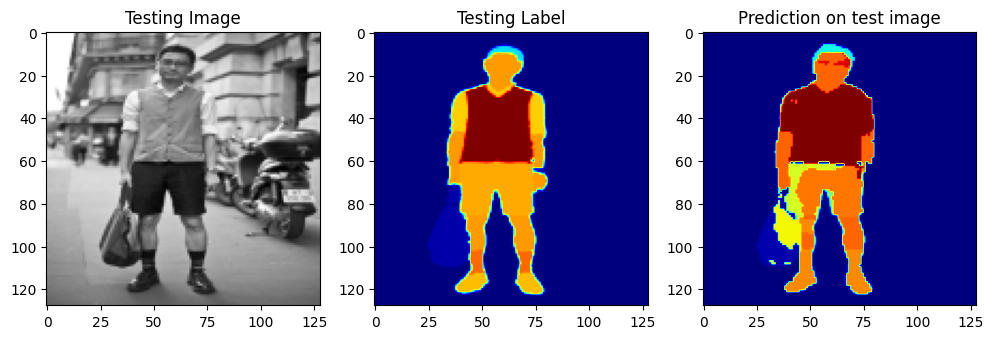

In [31]:
#Predict on a few images
#model = get_model()
#model.load_weights('???.hdf5')  
import random
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')
plt.show()